In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.model_selection import train_test_split

In [2]:
raw_df = pd.read_csv("Data/Fraud_Detection/application_data.csv").set_index('SK_ID_CURR')
raw_prev_df = pd.read_csv("Data/Fraud_Detection/previous_application.csv")

In [3]:
drop_raw = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY']
drop_prev = [
    'SK_ID_CURR',
    'SK_ID_PREV',
    'FLAG_LAST_APPL_PER_CONTRACT',
    'NFLAG_LAST_APPL_IN_DAY',
    'SELLERPLACE_AREA',
]

cat_col = [
    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'NAME_TYPE_SUITE',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'FLAG_EMP_PHONE',
    'FLAG_WORK_PHONE',
    'FLAG_CONT_MOBILE',
    'FLAG_PHONE',
    'FLAG_EMAIL',
    'OCCUPATION_TYPE',
    'WEEKDAY_APPR_PROCESS_START',
    'REG_REGION_NOT_LIVE_REGION',
    'REG_REGION_NOT_WORK_REGION',
    'LIVE_REGION_NOT_WORK_REGION',
    'REG_CITY_NOT_LIVE_CITY',
    'REG_CITY_NOT_WORK_CITY',
    'LIVE_CITY_NOT_WORK_CITY',
    'ORGANIZATION_TYPE',
    'FONDKAPREMONT_MODE',
    'HOUSETYPE_MODE',
    'WALLSMATERIAL_MODE',
    'EMERGENCYSTATE_MODE',
    'FLAG_DOCUMENT_2',
    'FLAG_DOCUMENT_3',
    'FLAG_DOCUMENT_4',
    'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6',
    'FLAG_DOCUMENT_7',
    'FLAG_DOCUMENT_8',
    'FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10',
    'FLAG_DOCUMENT_11',
    'FLAG_DOCUMENT_12',
    'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14',
    'FLAG_DOCUMENT_15',
    'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18',
    'FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20',
    'FLAG_DOCUMENT_21',
    'prev_NAME_CONTRACT_TYPE',
    'prev_WEEKDAY_APPR_PROCESS_START',
    'prev_NAME_CASH_LOAN_PURPOSE',
    'prev_NAME_CONTRACT_STATUS',
    'prev_NAME_PAYMENT_TYPE',
    'prev_CODE_REJECT_REASON',
    'prev_NAME_TYPE_SUITE',
    'prev_NAME_CLIENT_TYPE',
    'prev_NAME_GOODS_CATEGORY',
    'prev_NAME_PORTFOLIO',
    'prev_NAME_PRODUCT_TYPE',
    'prev_CHANNEL_TYPE',
    'prev_NAME_SELLER_INDUSTRY',
    'prev_NAME_YIELD_GROUP',
    'prev_PRODUCT_COMBINATION',
    'prev_NFLAG_INSURED_ON_APPROVAL'
]
target_col = 'TARGET'
feat_col=lambda oc: list(set(oc.columns)-set([target_col]))

In [4]:
# add kin

df = raw_df[raw_df.index.isin(raw_prev_df['SK_ID_CURR'])].drop(drop_raw, axis=1)
for col in raw_prev_df.drop(drop_prev, axis=1).columns:
    df["prev_" + col] = raw_prev_df[col]
uniq_val = df.apply(lambda c: c.unique())
current_col = df.columns.copy()
for col in current_col:
    if uniq_val[col].shape[0] <= 1: df=df.drop(col, axis=1)
(1 - df.shape[0] / raw_df.shape[0]) * 100

5.350702901684823

In [5]:
for col in df.columns:
    if col in cat_col+[target_col]: continue
    temp=df[col].dropna()
    a=temp.quantile(0.99)-temp.quantile(0.01)
    if a<0.001: a=temp.max()-temp.min()
    df[col] = (df[col]-temp.quantile(0.01))/(temp.quantile(0.99)-temp.quantile(0.01))

In [6]:
for col in cat_col:
    other_val = df[col].value_counts()<0.005*df.shape[0]
    other_val = [v for is_small,v in list(zip(other_val,other_val.index)) if is_small]
    df[col]=df[col].replace(other_val, 'other')

temp=[c for c in cat_col if df[c].value_counts().shape[0]==2]
for col in temp:
    unique_values = df[col].unique()
    df[col]=df[col].map({unique_values[0]: 0, unique_values[1]: 1})

temp=[c for c in cat_col if df[c].value_counts().shape[0]>2]
encoder=ce.BinaryEncoder(cols=temp,return_df=True)
df=encoder.fit_transform(df)


In [7]:
for col in df.columns:
    if df[col].isna().sum()==0: continue
    df[col+"_nan"]=df[col].isna().astype(np.int8)
df=df.fillna(0)

In [8]:
data_=df.copy()

In [9]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_regression

for cirt in [f_classif]:
    a = SelectKBest(cirt, k=100)
    a.fit(df[feat_col(df)], df[target_col])
    selected=a.get_feature_names_out()

In [28]:
X_train, X_test = pd.DataFrame(), pd.DataFrame()
df_tar,df_feat=df[target_col], df[selected]
for tr_val in df_tar.unique():
    train, test = train_test_split(df_feat[df_tar==tr_val], test_size=0.15, random_state=15)
    X_train=pd.concat([train,X_train])
    X_test= pd.concat([test, X_test])
y_train=df_tar[df_tar.index.isin(X_train.index)]
y_test=df_tar[df_tar.index.isin(X_test.index)]

In [22]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid={
    'n_estimators': [50, 100, 150],
    'max_depth': [20, 30, 40, 50],
    'bootstrap': [True, False]
})
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)


KeyboardInterrupt



In [29]:
model=RandomForestClassifier(class_weight={0: 1,1:12},max_depth=26, n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 12}, max_depth=26)

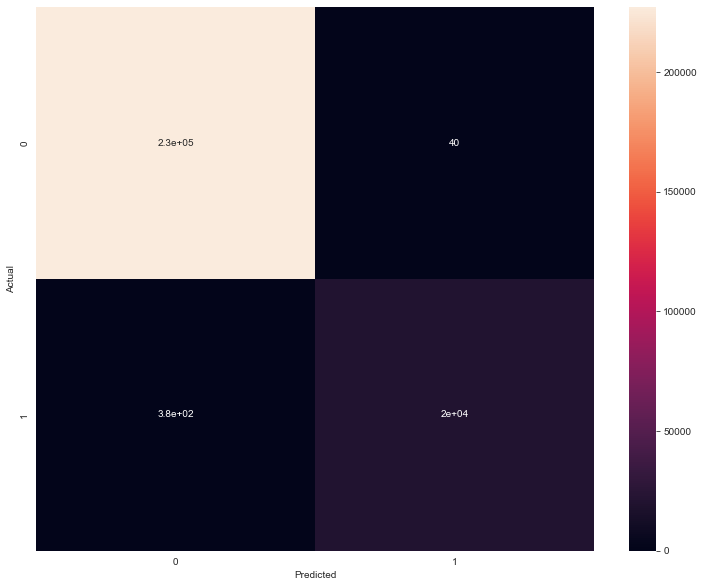

In [33]:
cm=confusion_matrix(y_test, model.predict(X_test))
s = sns.heatmap(cm, annot=True, vmin=0)
s.set(xlabel="Predicted", ylabel="Actual")
plt.gcf().set_size_inches(12.5, 10)
plt.show(s)

In [31]:
from sklearn.metrics import classification_report
classification_report(y_test, model.predict(X_test), output_dict=True)

{'0': {'precision': 0.918093273748138,
  'recall': 0.9994760740482012,
  'f1-score': 0.9570577063201022,
  'support': 40082},
 '1': {'precision': 0.125,
  'recall': 0.0008386916410399776,
  'f1-score': 0.0016662038322688142,
  'support': 3577},
 'accuracy': 0.9176572986096796,
 'macro avg': {'precision': 0.521546636874069,
  'recall': 0.5001573828446205,
  'f1-score': 0.4793619550761855,
  'support': 43659},
 'weighted avg': {'precision': 0.8531148124870671,
  'recall': 0.9176572986096796,
  'f1-score': 0.8787820837818175,
  'support': 43659}}

In [32]:
classification_report(y_train, model.predict(X_train), output_dict=True)

{'0': {'precision': 0.9983382277946788,
  'recall': 0.9998238894025449,
  'f1-score': 0.9990805062934726,
  'support': 227130},
 '1': {'precision': 0.9979929754139488,
  'recall': 0.9813499111900533,
  'f1-score': 0.989601472710085,
  'support': 20268},
 'accuracy': 0.9983104147972094,
 'macro avg': {'precision': 0.9981656016043139,
  'recall': 0.990586900296299,
  'f1-score': 0.9943409895017787,
  'support': 247398},
 'weighted avg': {'precision': 0.9983099431066352,
  'recall': 0.9983104147972094,
  'f1-score': 0.998303939576409,
  'support': 247398}}

In [26]:
a=list(zip(df_feat.columns,model.feature_importances_))
a.sort(key=lambda x: x[1])
list(zip(*a[-10:]))

[('EXT_SOURCE_3',
  'DAYS_EMPLOYED',
  'AMT_CREDIT',
  'DAYS_LAST_PHONE_CHANGE',
  'prev_DAYS_DECISION',
  'AMT_ANNUITY',
  'DAYS_BIRTH',
  'DAYS_ID_PUBLISH',
  'DAYS_REGISTRATION',
  'EXT_SOURCE_2'),
 (0.018316121253392742,
  0.019090280852935976,
  0.01976389889644832,
  0.02047046878219962,
  0.021265713688748453,
  0.021844761097262837,
  0.02205096088369158,
  0.02279130767561258,
  0.02285910659491517,
  0.022980409238233572)]